<a href="https://colab.research.google.com/github/JuniorHZ19/HerramientasIA/blob/main/srgandemo1.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip # This is our dataset link. I will include this command in the description

In [1]:
# Do set your runtime to GPU. You will need it
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable

In [ ]:
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
from PIL import Image

In [ ]:
from os.path import join

In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
# Now, I will load in some code for the dataset and dataloaders.
# Link to this notebook will be in the description, so you can get it from there
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])


class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [ ]:
# That was the dataset code.
# Now lets load the train set
# Forgot to import join from os.path

In [ ]:
train_set = TrainDatasetFromFolder("DIV2K_train_HR", crop_size=CROP_SIZE,
                                   upscale_factor=UPSCALE_FACTOR)
trainloader = DataLoader(train_set, batch_size=64, num_workers=4, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
from torch import nn, optim

In [4]:
# Now we will start implementing the model. We will start in this vid, and co,plee
# in the next video
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)
  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + residual

# We just implemented a pretty standard residual block here

In [5]:
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                          kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()
  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

In [6]:
class Generator(nn.Module):
  def __init__(self, scale_factor):
    super(Generator, self).__init__()
    upsample_block_num = int(math.log(scale_factor, 2))

    self.block1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )

    self.block2 = ResidualBlock(64)
    self.block3 = ResidualBlock(64)
    self.block4 = ResidualBlock(64)
    self.block5 = ResidualBlock(64)
    self.block6 = ResidualBlock(64)
    self.block7 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
    block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
    self.block8 = nn.Sequential(*block8)
  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    block7 = self.block7(block6)
    block8 = self.block8(block1 + block7)
    return (torch.tanh(block8) + 1) / 2

921600


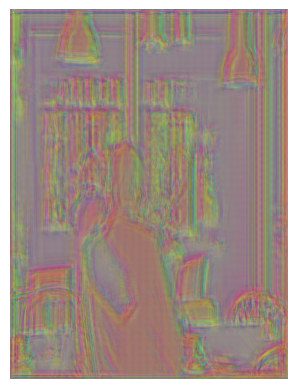

torch.Size([1, 3, 640, 480])


In [41]:
from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

generador=Generator(2)
ruta_imagen = "/content/lw_42.png"
imagen = Image.open(ruta_imagen)

transformador = ToTensor()

#original iamgen tensor
tensor_imagen = transformador(imagen).unsqueeze(0)

#imagen generada
imagen_generada=generador(tensor_imagen)


imagen_generada_numpy=imagen_generada.squeeze().detach().numpy().transpose(1, 2, 0)
print(imagen_generada_numpy.size)

plt.imshow(imagen_generada_numpy)  # Transponer las dimensiones del canal
plt.axis('off')  # Desactivar ejes
plt.show()
print (generador(tensor_imagen).shape)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1)
    )
  def forward(self, x):
    batch_size=x.size()[0]
    return torch.sigmoid(self.net(x).view(batch_size))

In [ ]:
from torchvision.models.vgg import vgg16

In [ ]:
# Now we got to make the Generator Loss
class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    count_h = self.tensor_size(x[:, :, 1:, :])
    count_w = self.tensor_size(x[:, :, :, 1:])

    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  # Forgot to implement an important method
  @staticmethod # Must add this
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]

In [ ]:
class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss, self).__init__()
    vgg = vgg16(pretrained=True)
    loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
    for param in loss_network.parameters():
      param.requires_grad = False
    self.loss_network = loss_network
    self.mse_loss = nn.MSELoss()
    self.tv_loss = TVLoss()
  def forward(self, out_labels, out_images, target_images):
    adversial_loss = torch.mean(1 - out_labels)
    perception_loss = self.mse_loss(out_images, target_images)
    image_loss = self.mse_loss(out_images, target_images)
    tv_loss = self.tv_loss(out_images)
    return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


In [ ]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Standard device selectoin
device

device(type='cuda')

In [ ]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

In [ ]:
generator_criterion = GeneratorLoss()

In [ ]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [ ]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [ ]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

In [ ]:
## Now for training code
from tqdm import tqdm
import os

In [ ]:
N_EPOCHS = 150 # 150 is good enough for our model. gives decent enough results

In [ ]:
for epoch in range(1, N_EPOCHS + 1):
  train_bar = tqdm(trainloader)
  running_results = {'batch_sizes':0, 'd_loss':0,
                     "g_loss":0, "d_score":0, "g_score":0}

  netG.train()
  netD.train()
  for data, target in train_bar:
    g_update_first = True
    batch_size = data.size(0)
    running_results['batch_sizes'] += batch_size

    real_img = Variable(target)
    real_img = real_img.to(device)
    z = Variable(data)
    z = z.to(device)

    ## Update Discriminator ##
    fake_img = netG(z)
    netD.zero_grad()
    real_out = netD(real_img).mean()
    fake_out = netD(fake_img).mean()
    d_loss = 1 - real_out + fake_out
    d_loss.backward(retain_graph = True)
    optimizerD.step()

    ## Now update Generator
    fake_img = netG(z)
    fake_out = netD(fake_img).mean()
    netG.zero_grad()
    g_loss = generator_criterion(fake_out, fake_img, real_img)
    g_loss.backward()

    fake_img = netG(z)
    fake_out = netD(fake_img).mean()

    optimizerG.step()

    running_results['g_loss'] += g_loss.item() * batch_size
    running_results['d_loss'] += d_loss.item() * batch_size
    running_results['d_score'] += real_out.item() * batch_size
    running_results['g_score'] += real_out.item() * batch_size

    ## Updating the progress bar
    train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f" % (
        epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
        running_results['g_loss'] / running_results['batch_sizes'],
        running_results['d_score'] / running_results['batch_sizes'],
        running_results['g_score'] / running_results['batch_sizes']
    ))
  netG.eval()

Streaming output truncated to the last 5000 lines.




[27/150] Loss_D: 0.0470 Loss_G: 0.0067 D(x): 0.9678 D(G(z)): 0.9678:  38%|███▊      | 5/13 [00:38<01:13,  9.20s/it]






[27/150] Loss_D: 0.0470 Loss_G: 0.0067 D(x): 0.9678 D(G(z)): 0.9678:  46%|████▌     | 6/13 [00:38<00:48,  6.94s/it]






[27/150] Loss_D: 0.0476 Loss_G: 0.0068 D(x): 0.9660 D(G(z)): 0.9660:  46%|████▌     | 6/13 [00:40<00:48,  6.94s/it]






[27/150] Loss_D: 0.0476 Loss_G: 0.0068 D(x): 0.9660 D(G(z)): 0.9660:  54%|█████▍    | 7/13 [00:40<00:32,  5.36s/it]






[27/150] Loss_D: 0.0431 Loss_G: 0.0071 D(x): 0.9692 D(G(z)): 0.9692:  54%|█████▍    | 7/13 [00:41<00:32,  5.36s/it]






[27/150] Loss_D: 0.0431 Loss_G: 0.0071 D(x): 0.9692 D(G(z)): 0.9692:  62%|██████▏   | 8/13 [00:41<00:21,  4.26s/it]






[27/150] Loss_D: 0.0664 Loss_G: 0.0072 D(x): 0.9699 D(G(z)): 0.9699:  62%|██████▏   | 8/13 [00:54<00:21,  4.26s/it]






[27/150] Loss_D: 0.0664 Loss_G: 0.0072 D(x): 0.9699 D(G(z)): 0.9699:  69%|██████▉   | 9/13 

In [ ]:
# We will just make sure that this model trains 5 epochs successfuly
# This will take around 2 hours to train, please monitor colab
# To make sure that it does not time out
# There might be few errors, mostly due to typos
# The progress bar acts slightly weird
# But you see the model is now training
